In [1]:
import torch
print(torch.cuda.is_available())  # True, если GPU доступен
print(torch.cuda.get_device_name(0))  # Название GPU

True
Tesla T4


## Модель

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import cv2
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from datetime import timedelta
from torch.cuda.amp import autocast, GradScaler

In [4]:
# Создадим нужные классы для модели
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

In [5]:
class UNetResNet34(nn.Module):
    def __init__(self, num_keypoints=21):
        super().__init__()
        resnet = models.resnet34(pretrained=True)

        self.input_block = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.encoder1 = resnet.layer1  # 64 channels
        self.encoder2 = resnet.layer2  # 128 channels
        self.encoder3 = resnet.layer3  # 256 channels
        self.encoder4 = resnet.layer4  # 512 channels

        # Декодеры с проверкой размерностей
        self.up4 = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec4 = ConvBlock(256+256, 256)

        self.up3 = nn.Sequential(
            nn.Conv2d(256, 128, 1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec3 = ConvBlock(128+128, 128)

        self.up2 = nn.Sequential(
            nn.Conv2d(128, 64, 1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec2 = ConvBlock(64+64, 64)

        self.up1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec1 = ConvBlock(64+64, 64)

        self.final_conv = nn.Conv2d(64, num_keypoints, 1)

    def forward(self, x):
        # Запоминаем исходный размер для финального ресайза
        input_size = x.size()[2:]
        
        # Encoder path
        x0 = self.input_block(x)  # 1/4 размера входа
        x1 = self.encoder1(x0)    # 1/4 размера входа
        x2 = self.encoder2(x1)    # 1/8 размера входа
        x3 = self.encoder3(x2)    # 1/16 размера входа
        x4 = self.encoder4(x3)    # 1/32 размера входа
        
        # Decoder path с resize для гарантии совпадения размерностей
        d4 = self.up4(x4)  # 1/16 размера входа
        # Обеспечиваем одинаковый размер с x3
        if d4.size()[2:] != x3.size()[2:]:
            d4 = F.interpolate(d4, size=x3.size()[2:], mode='bilinear', align_corners=True)
        d4 = self.dec4(torch.cat([d4, x3], dim=1))
        
        d3 = self.up3(d4)  # 1/8 размера входа
        # Обеспечиваем одинаковый размер с x2
        if d3.size()[2:] != x2.size()[2:]:
            d3 = F.interpolate(d3, size=x2.size()[2:], mode='bilinear', align_corners=True)
        d3 = self.dec3(torch.cat([d3, x2], dim=1))
        
        d2 = self.up2(d3)  # 1/4 размера входа
        # Обеспечиваем одинаковый размер с x1
        if d2.size()[2:] != x1.size()[2:]:
            d2 = F.interpolate(d2, size=x1.size()[2:], mode='bilinear', align_corners=True)
        d2 = self.dec2(torch.cat([d2, x1], dim=1))
        
        d1 = self.up1(d2)  # 1/2 размера входа
        # Обеспечиваем одинаковый размер с x0
        if d1.size()[2:] != x0.size()[2:]:
            d1 = F.interpolate(d1, size=x0.size()[2:], mode='bilinear', align_corners=True)
        d1 = self.dec1(torch.cat([d1, x0], dim=1))
        
        # Финальная свертка
        out = self.final_conv(d1)
        
        # Финальный ресайз до размера входа
        if out.size()[2:] != input_size:
            out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        
        return out

In [6]:
# Для отрисовки ключевых точек
def heatmaps_to_keypoints(heatmaps):
    B, K, H, W = heatmaps.shape
    keypoints = []
    for i in range(B):
        kp = []
        for j in range(K):
            hmap = heatmaps[i, j]
            y, x = torch.argmax(hmap.view(-1), dim=0) // W, torch.argmax(hmap.view(-1), dim=0) % W
            kp.append([x.item(), y.item()])
        keypoints.append(kp)
    return np.array(keypoints)

def draw_keypoints(image, keypoints, radius=3, color=(0, 255, 0)):
    img = image.copy()
    for (x, y) in keypoints:
        cv2.circle(img, (int(x), int(y)), radius, color, -1)
    return img

def denormalize_image(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Денормализация изображения после albumentations.Normalize()
    """
    img = img_tensor.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

def show_image_with_keypoints(image_tensor, keypoints, save_path=None):
    img = denormalize_image(image_tensor)
    img = img.permute(1, 2, 0).numpy()  # (H, W, C)
    img = (img * 255).astype(np.uint8)  # В диапазон 0-255

    img_kp = draw_keypoints(img, keypoints)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_kp)
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        print(f"Изображение сохранено в {save_path}")
    else:
        plt.show()

In [7]:
# СОздадим класс для работы с датасетом
from tqdm import tqdm
IMAGE_SIZE = 256
class FreiHandDataset(Dataset):
    def __init__(self, image_dir, annot_path, transform=None, precalculate_heatmaps=False):
        self.image_dir = image_dir
        self.transform = transform
        
        # Загрузка аннотаций
        print("Загрузка аннотаций...")
        with open(annot_path, 'r') as f:
            self.annotations = json.load(f)
            
        self.precalculate_heatmaps = precalculate_heatmaps
        self.heatmaps_cache = {}
        
        # Предварительное вычисление тепловых карт (если включено)
        if precalculate_heatmaps:
            print("Предварительный расчет тепловых карт...")
            for idx in tqdm(range(len(self.annotations))):
                ann = self.annotations[idx]
                keypoints = np.array(ann['keypoints']).reshape(-1, 2).tolist()
                self.heatmaps_cache[idx] = self._generate_heatmaps(keypoints)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = os.path.join(self.image_dir, ann['file_name'])
        
        # Загрузка изображения
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        keypoints = np.array(ann['keypoints']).reshape(-1, 2).tolist()
    
        # Применение аугментаций
        if self.transform:
            augmented = self.transform(image=image, keypoints=keypoints)
            image = augmented['image']
            keypoints = augmented['keypoints']
    
        # Используем кэш или создаем тепловые карты
        if self.precalculate_heatmaps and idx in self.heatmaps_cache:
            heatmaps = self.heatmaps_cache[idx]
        else:
            heatmaps = self._generate_heatmaps(keypoints, shape=(IMAGE_SIZE, IMAGE_SIZE), sigma=2)
    
        return image, torch.tensor(heatmaps, dtype=torch.float32)

    def _generate_heatmaps(self, keypoints, shape=(IMAGE_SIZE, IMAGE_SIZE), sigma=2):
        w, h = shape
        heatmaps = np.zeros((21, h, w))
        
        # Генерируем сетку один раз
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        
        for i, (x, y) in enumerate(keypoints):
            if x < 0 or y < 0 or x >= w or y >= h:
                continue
            # Более эффективная генерация тепловых карт
            heatmaps[i] = np.exp(-((xx - x) ** 2 + (yy - y) ** 2) / (2 * sigma ** 2))
        
        return heatmaps

# Функция для создания трансформаций
def get_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

## Работа с датасетом FreiHand

In [8]:
def create_cached_dataset(image_dir, annot_path, transform=None):
    """
    Создает предварительно обработанный датасет для ускорения загрузки
    """
    print("Создание кэшированного датасета...")
    dataset = FreiHandDataset(image_dir, annot_path, transform=transform)
    cached_data = []
    
    for idx in tqdm(range(len(dataset))):
        try:
            image, heatmap = dataset[idx]
            cached_data.append((image, heatmap))
        except Exception as e:
            print(f"Ошибка при обработке изображения {idx}: {e}")
    
    class CachedDataset(Dataset):
        def __init__(self, data):
            self.data = data
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, idx):
            return self.data[idx]
    
    return CachedDataset(cached_data)


In [9]:
# Создадим файл annotations.json с координамики ключевых точек для каждого изображения
import pickle
import json
import numpy as np

In [10]:
# image_dir = '/Users/alinamiller/Desktop/FreiHAND_pub_v2/training/rgb'
image_dir = '/kaggle/input/rgb-images/rgb/'
annot_path = '/kaggle/input/annonations/annotations.json'

In [11]:
# image_dir = DATASET_PATH
dataset_train = FreiHandDataset(image_dir, annot_path, transform=get_transforms())
# dataset_test = FreiHandDataset(image_dir, annot_path, transform=get_transforms())

Загрузка аннотаций...


In [12]:
def train_model(model, dataloader, num_epochs, device, use_mixed_precision=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Настройка смешанной точности, если включено
    scaler = GradScaler() if use_mixed_precision else None
    
    model.train()
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        
        # Прогресс-бар для эпохи
        with tqdm(dataloader, desc=f"Эпоха {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for i, (images, heatmaps) in enumerate(tepoch):
                # Перемещаем данные на устройство
                images = images.to(device, non_blocking=True)
                heatmaps = heatmaps.to(device, non_blocking=True)
                
                # Обнуляем градиенты
                optimizer.zero_grad(set_to_none=True)  # Более эффективно
                
                if use_mixed_precision:
                    # Используем смешанную точность
                    with autocast():
                        preds = model(images)
                        loss = F.mse_loss(preds, heatmaps)
                    
                    # Масштабирование потери
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    # Стандартное обучение
                    preds = model(images)
                    loss = F.mse_loss(preds, heatmaps)
                    loss.backward()
                    optimizer.step()
                
                # Обновляем информацию о потерях
                running_loss += loss.item()
                current_loss = running_loss / (i + 1)
                
                # Обновляем progress bar
                tepoch.set_postfix(loss=f"{current_loss:.4f}")
        
        # Время, затраченное на эпоху
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - total_start_time
        avg_epoch_time = total_time / (epoch + 1)
        estimated_time_left = avg_epoch_time * (num_epochs - epoch - 1)
        
        print(f"Эпоха {epoch+1}/{num_epochs} завершена за {timedelta(seconds=int(epoch_time))}")
        print(f"Средняя потеря: {running_loss/len(dataloader):.4f}")
        print(f"Прошло времени: {timedelta(seconds=int(total_time))}")
        print(f"Осталось времени (примерно): {timedelta(seconds=int(estimated_time_left))}")
        print("-" * 60)
    
    total_training_time = time.time() - total_start_time
    print(f"Обучение завершено за {timedelta(seconds=int(total_training_time))}")
    
    return model

In [13]:
# Проверка доступности GPU
print(f"CUDA доступен: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Используемый GPU: {torch.cuda.get_device_name(0)}")
    
# Создаем датасет
print("Инициализация датасета...")
    
BATCH_SIZE = 4
NUM_EPOCHS = 30
NUM_WORKERS = 4
USE_MIXED_PRECISION = True
LEARNING_RATE = 1e-4

CUDA доступен: True
Используемый GPU: Tesla T4
Инициализация датасета...


In [14]:
dataset_train = create_cached_dataset(image_dir, annot_path, transform=get_transforms())
    
# Создаем загрузчик данных с оптимизациями
dataloader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS,  # Параллельная загрузка
    pin_memory=True,  # Ускорение передачи данных на GPU
    persistent_workers=(NUM_WORKERS > 0),  # Сохраняем рабочие процессы между эпохами
    prefetch_factor=2  # Предварительная загрузка
    )

Создание кэшированного датасета...
Загрузка аннотаций...


100%|██████████| 3256/3256 [12:39<00:00,  4.29it/s]


In [19]:
# Функция для предсказания и визуализации результатов
def predict_and_visualize(model, dataloader, device, num_samples=4):
    model.eval()
    
    # Получаем батч из загрузчика данных
    images, _ = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        preds = model(images)
        
    # Конвертируем тепловые карты в координаты ключевых точек
    keypoints_batch = heatmaps_to_keypoints(preds.cpu())
    
    # Визуализируем результаты
    for i in range(min(num_samples, len(images))):
        show_image_with_keypoints(images[i].cpu(), keypoints_batch[i], 
                                  save_path=f"output_keypoints_{i}.png")
    
    return keypoints_batch

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [17]:
model = UNetResNet34().to(device)
    
# Обучение модели
model = train_model(
    model=model,
    dataloader=dataloader,
    num_epochs=NUM_EPOCHS,
    device=device,
    use_mixed_precision=USE_MIXED_PRECISION
    )

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]
Эпоха 1/30: 100%|██████████| 814/814 [00:40<00:00, 20.10batch/s, loss=0.0033]


Эпоха 1/30 завершена за 0:00:40
Средняя потеря: 0.0033
Прошло времени: 0:00:40
Осталось времени (примерно): 0:19:34
------------------------------------------------------------


Эпоха 2/30: 100%|██████████| 814/814 [00:36<00:00, 22.58batch/s, loss=0.0003]


Эпоха 2/30 завершена за 0:00:36
Средняя потеря: 0.0003
Прошло времени: 0:01:16
Осталось времени (примерно): 0:17:51
------------------------------------------------------------


Эпоха 3/30: 100%|██████████| 814/814 [00:35<00:00, 22.62batch/s, loss=0.0002]


Эпоха 3/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:01:52
Осталось времени (примерно): 0:16:52
------------------------------------------------------------


Эпоха 4/30: 100%|██████████| 814/814 [00:36<00:00, 22.20batch/s, loss=0.0002]


Эпоха 4/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:02:29
Осталось времени (примерно): 0:16:09
------------------------------------------------------------


Эпоха 5/30: 100%|██████████| 814/814 [00:36<00:00, 22.56batch/s, loss=0.0002]


Эпоха 5/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:03:05
Осталось времени (примерно): 0:15:26
------------------------------------------------------------


Эпоха 6/30: 100%|██████████| 814/814 [00:36<00:00, 22.48batch/s, loss=0.0002]


Эпоха 6/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:03:41
Осталось времени (примерно): 0:14:45
------------------------------------------------------------


Эпоха 7/30: 100%|██████████| 814/814 [00:36<00:00, 22.52batch/s, loss=0.0002]


Эпоха 7/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:04:17
Осталось времени (примерно): 0:14:06
------------------------------------------------------------


Эпоха 8/30: 100%|██████████| 814/814 [00:35<00:00, 22.69batch/s, loss=0.0002]


Эпоха 8/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:04:53
Осталось времени (примерно): 0:13:27
------------------------------------------------------------


Эпоха 9/30: 100%|██████████| 814/814 [00:36<00:00, 22.51batch/s, loss=0.0002]


Эпоха 9/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:05:29
Осталось времени (примерно): 0:12:49
------------------------------------------------------------


Эпоха 10/30: 100%|██████████| 814/814 [00:35<00:00, 22.65batch/s, loss=0.0002]


Эпоха 10/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:06:05
Осталось времени (примерно): 0:12:11
------------------------------------------------------------


Эпоха 11/30: 100%|██████████| 814/814 [00:35<00:00, 22.77batch/s, loss=0.0002]


Эпоха 11/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:06:41
Осталось времени (примерно): 0:11:33
------------------------------------------------------------


Эпоха 12/30: 100%|██████████| 814/814 [00:36<00:00, 22.47batch/s, loss=0.0002]


Эпоха 12/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:07:17
Осталось времени (примерно): 0:10:56
------------------------------------------------------------


Эпоха 13/30: 100%|██████████| 814/814 [00:36<00:00, 22.51batch/s, loss=0.0002]


Эпоха 13/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:07:53
Осталось времени (примерно): 0:10:19
------------------------------------------------------------


Эпоха 14/30: 100%|██████████| 814/814 [00:35<00:00, 22.66batch/s, loss=0.0002]


Эпоха 14/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:08:29
Осталось времени (примерно): 0:09:42
------------------------------------------------------------


Эпоха 15/30: 100%|██████████| 814/814 [00:36<00:00, 22.54batch/s, loss=0.0002]


Эпоха 15/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:09:05
Осталось времени (примерно): 0:09:05
------------------------------------------------------------


Эпоха 16/30: 100%|██████████| 814/814 [00:36<00:00, 22.35batch/s, loss=0.0002]


Эпоха 16/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:09:42
Осталось времени (примерно): 0:08:29
------------------------------------------------------------


Эпоха 17/30: 100%|██████████| 814/814 [00:35<00:00, 22.65batch/s, loss=0.0002]


Эпоха 17/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:10:18
Осталось времени (примерно): 0:07:52
------------------------------------------------------------


Эпоха 18/30: 100%|██████████| 814/814 [00:35<00:00, 22.61batch/s, loss=0.0002]


Эпоха 18/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:10:54
Осталось времени (примерно): 0:07:16
------------------------------------------------------------


Эпоха 19/30: 100%|██████████| 814/814 [00:36<00:00, 22.49batch/s, loss=0.0002]


Эпоха 19/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:11:30
Осталось времени (примерно): 0:06:39
------------------------------------------------------------


Эпоха 20/30: 100%|██████████| 814/814 [00:35<00:00, 22.65batch/s, loss=0.0002]


Эпоха 20/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:12:06
Осталось времени (примерно): 0:06:03
------------------------------------------------------------


Эпоха 21/30: 100%|██████████| 814/814 [00:36<00:00, 22.44batch/s, loss=0.0002]


Эпоха 21/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:12:42
Осталось времени (примерно): 0:05:26
------------------------------------------------------------


Эпоха 22/30: 100%|██████████| 814/814 [00:36<00:00, 22.37batch/s, loss=0.0002]


Эпоха 22/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:13:18
Осталось времени (примерно): 0:04:50
------------------------------------------------------------


Эпоха 23/30: 100%|██████████| 814/814 [00:35<00:00, 22.62batch/s, loss=0.0002]


Эпоха 23/30 завершена за 0:00:35
Средняя потеря: 0.0002
Прошло времени: 0:13:54
Осталось времени (примерно): 0:04:14
------------------------------------------------------------


Эпоха 24/30: 100%|██████████| 814/814 [00:36<00:00, 22.44batch/s, loss=0.0002]


Эпоха 24/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:14:31
Осталось времени (примерно): 0:03:37
------------------------------------------------------------


Эпоха 25/30: 100%|██████████| 814/814 [00:36<00:00, 22.60batch/s, loss=0.0002]


Эпоха 25/30 завершена за 0:00:36
Средняя потеря: 0.0002
Прошло времени: 0:15:07
Осталось времени (примерно): 0:03:01
------------------------------------------------------------


Эпоха 26/30: 100%|██████████| 814/814 [00:36<00:00, 22.51batch/s, loss=0.0001]


Эпоха 26/30 завершена за 0:00:36
Средняя потеря: 0.0001
Прошло времени: 0:15:43
Осталось времени (примерно): 0:02:25
------------------------------------------------------------


Эпоха 27/30: 100%|██████████| 814/814 [00:35<00:00, 22.61batch/s, loss=0.0001]


Эпоха 27/30 завершена за 0:00:36
Средняя потеря: 0.0001
Прошло времени: 0:16:19
Осталось времени (примерно): 0:01:48
------------------------------------------------------------


Эпоха 28/30: 100%|██████████| 814/814 [00:35<00:00, 22.85batch/s, loss=0.0001]


Эпоха 28/30 завершена за 0:00:35
Средняя потеря: 0.0001
Прошло времени: 0:16:55
Осталось времени (примерно): 0:01:12
------------------------------------------------------------


Эпоха 29/30: 100%|██████████| 814/814 [00:36<00:00, 22.52batch/s, loss=0.0001]


Эпоха 29/30 завершена за 0:00:36
Средняя потеря: 0.0001
Прошло времени: 0:17:31
Осталось времени (примерно): 0:00:36
------------------------------------------------------------


Эпоха 30/30: 100%|██████████| 814/814 [00:35<00:00, 22.75batch/s, loss=0.0001]

Эпоха 30/30 завершена за 0:00:35
Средняя потеря: 0.0001
Прошло времени: 0:18:06
Осталось времени (примерно): 0:00:00
------------------------------------------------------------
Обучение завершено за 0:18:06


In [18]:
# # Сохранение модели
torch.save(model.state_dict(), "/kaggle/working/pose_estimation_model.pth")
# print("Модель сохранена в pose_estimation_model.pth")

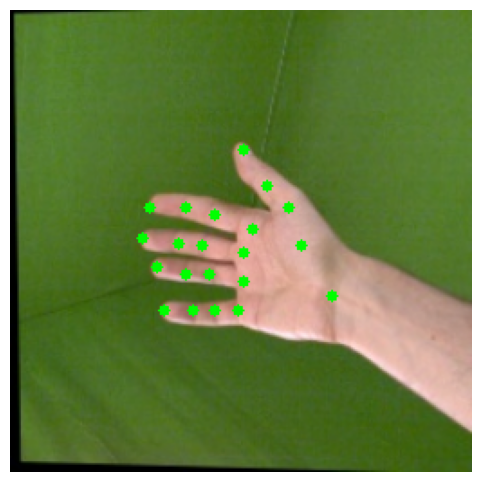

In [32]:
# Отрисуем точки на нескольких изображениях, которые модель не видела при обучении
model.eval()
model.to(device)
images, _ = next(iter(dataloader))
images = images.to(device)

# images, _ = next(iter(dataloader))
with torch.no_grad():
    preds = model(images)
    keypoints = heatmaps_to_keypoints(preds.cpu())[2]

show_image_with_keypoints(images[2], keypoints)

Изображение сохранено в output_keypoints.png


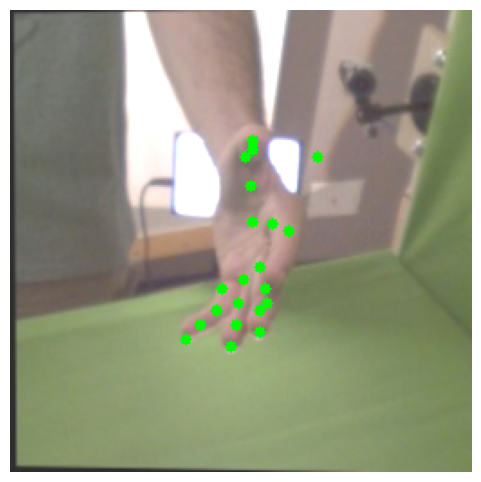

In [30]:
show_image_with_keypoints(images[2], keypoints, save_path="output_keypoints.png")

## Работа с видео

In [33]:
def extract_frames_from_video(video_path, output_dir):
    # Создаем папку, если её нет
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  

        frame_filename = os.path.join(output_dir, f"frame_{frame_idx:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        
        frame_idx += 1

    cap.release()
    print(f"Сохранено {frame_idx} кадров в папку: {output_dir}")

In [22]:
def process_frames(frames_dir, model_path, output_dir, finger_index=8, trajectory_length=30):
    """
    Обрабатывает кадры и сохраняет результаты в output_dir
    """
    # Создаем директорию для вывода, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    # Настройки
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используется устройство: {device}")
    image_size = 256
    
    # Загружаем модель
    try:
        model = UNetResNet34(num_keypoints=21).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        print("Модель успешно загружена")
    except Exception as e:
        print(f"Ошибка при загрузке модели: {e}")
        return
    
    # Загружаем список кадров
    frames = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    print(f"Найдено {len(frames)} кадров")
    
    # История траектории
    trajectory = []
    
    # Обработка кадров
    with torch.no_grad():
        for i, frame_name in enumerate(tqdm(frames, desc="Обработка кадров")):
            try:
                frame_path = os.path.join(frames_dir, frame_name)
                frame = cv2.imread(frame_path)
                if frame is None:
                    print(f"Не удалось прочитать кадр: {frame_path}")
                    continue
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                orig_h, orig_w = frame.shape[:2]
                
                # Подготовка изображения
                frame_resized = cv2.resize(frame_rgb, (image_size, image_size))
                frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).float() / 255.0
                frame_tensor = (frame_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)) / torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
                frame_tensor = frame_tensor.unsqueeze(0).to(device)
                
                # Предсказание
                preds = model(frame_tensor)
                keypoints = heatmaps_to_keypoints(preds.cpu())[0]
                
                # Масштабируем координаты в оригинальный размер
                keypoints_scaled = keypoints * np.array([orig_w / image_size, orig_h / image_size])
                
                # Добавляем координату кончика указательного пальца в траекторию
                finger_point = keypoints_scaled[finger_index]
                trajectory.append(finger_point)
                
                # Ограничиваем длину хвоста траектории
                if len(trajectory) > trajectory_length:
                    trajectory = trajectory[-trajectory_length:]
                
                # Рисуем ключевые точки и траекторию на копии кадра
                frame_vis = frame.copy()
                for (x, y) in keypoints_scaled:
                    cv2.circle(frame_vis, (int(x), int(y)), 3, (0, 255, 0), -1)
                
                # Рисуем траекторию
                for j in range(1, len(trajectory)):
                    pt1 = (int(trajectory[j-1][0]), int(trajectory[j-1][1]))
                    pt2 = (int(trajectory[j][0]), int(trajectory[j][1]))
                    cv2.line(frame_vis, pt1, pt2, (0, 0, 255), 2)
                
                # Рисуем текущую точку пальца
                cv2.circle(frame_vis, (int(finger_point[0]), int(finger_point[1])), 6, (255, 0, 0), -1)
                
                # Сохраняем результат вместо отображения
                output_path = os.path.join(output_dir, f"result_{i:04d}.jpg")
                cv2.imwrite(output_path, frame_vis)
                
            except Exception as e:
                print(f"Ошибка при обработке кадра {frame_name}: {e}")
    
    print(f"Обработка завершена. Результаты сохранены в {output_dir}")
    
    # Создаем итоговую визуализацию траектории на последнем кадре
    if frames and len(trajectory) > 1:
        # Загружаем последний кадр
        last_frame = cv2.imread(os.path.join(frames_dir, frames[-1]))
        
        # Рисуем всю траекторию
        for j in range(1, len(trajectory)):
            pt1 = (int(trajectory[j-1][0]), int(trajectory[j-1][1]))
            pt2 = (int(trajectory[j][0]), int(trajectory[j][1]))
            # Используем цветовой градиент от синего к красному
            color = (
                int(255 * j / len(trajectory)),  # Red
                0,                                # Green
                int(255 * (1 - j / len(trajectory)))  # Blue
            )
            cv2.line(last_frame, pt1, pt2, color, 2)
        
        # Сохраняем итоговую траекторию
        cv2.imwrite(os.path.join(output_dir, "full_trajectory.jpg"), last_frame)
        
        # Создаем и сохраняем график траектории
        plt.figure(figsize=(10, 8))
        xs = [p[0] for p in trajectory]
        ys = [p[1] for p in trajectory]
        plt.plot(xs, ys, 'b-')
        plt.scatter(xs, ys, c=range(len(xs)), cmap='cool', s=50)
        plt.title('Траектория движения пальца')
        plt.gca().invert_yaxis()  # Инвертируем ось Y для соответствия координатам изображения
        plt.savefig(os.path.join(output_dir, "trajectory_plot.png"))
        plt.close()



In [34]:
def process_frames(frames_dir, model_path, output_dir, finger_index=8, trajectory_length=30, 
                max_displacement=50, smoothing_window=5):
    """
    Обрабатывает кадры и сохраняет результаты в output_dir с улучшенной обработкой траектории
    
    Параметры:
    - frames_dir: директория с кадрами
    - model_path: путь к модели
    - output_dir: директория для вывода результатов
    - finger_index: индекс точки для отслеживания (8 - кончик указательного пальца)
    - trajectory_length: максимальная длина траектории для визуализации
    - max_displacement: максимальное перемещение между кадрами (для фильтрации)
    - smoothing_window: размер окна для сглаживания траектории
    """
    import os
    import cv2
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    from scipy.signal import savgol_filter
    
    # Создаем директорию для вывода, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    # Настройки
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используется устройство: {device}")
    image_size = 256
    
    # Загружаем модель
    try:
        model = UNetResNet34(num_keypoints=21).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        print("Модель успешно загружена")
    except Exception as e:
        print(f"Ошибка при загрузке модели: {e}")
        return
    
    # Загружаем список кадров
    frames = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    print(f"Найдено {len(frames)} кадров")
    
    # История траектории (сохраняем все точки)
    raw_trajectory = []
    filtered_trajectory = []
    confidences = []  # Для хранения уверенности модели в предсказаниях
    
    # Первый проход - получение всех точек траектории и их фильтрация
    print("Первый проход: получение координат...")
    with torch.no_grad():
        for i, frame_name in enumerate(tqdm(frames, desc="Обработка кадров")):
            try:
                frame_path = os.path.join(frames_dir, frame_name)
                frame = cv2.imread(frame_path)
                if frame is None:
                    print(f"Не удалось прочитать кадр: {frame_path}")
                    continue
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                orig_h, orig_w = frame.shape[:2]
                
                # Подготовка изображения
                frame_resized = cv2.resize(frame_rgb, (image_size, image_size))
                frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).float() / 255.0
                frame_tensor = (frame_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)) / torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
                frame_tensor = frame_tensor.unsqueeze(0).to(device)
                
                # Предсказание
                preds = model(frame_tensor)
                keypoints = heatmaps_to_keypoints(preds.cpu())[0]
                
                # Получаем также максимальную уверенность из heatmap для каждой точки
                heatmaps = preds[0].cpu().numpy()
                confidence = np.max(heatmaps[finger_index])
                confidences.append(confidence)
                
                # Масштабируем координаты в оригинальный размер
                keypoints_scaled = keypoints * np.array([orig_w / image_size, orig_h / image_size])
                
                # Добавляем координату пальца в траекторию
                finger_point = keypoints_scaled[finger_index]
                raw_trajectory.append(finger_point)
                
            except Exception as e:
                print(f"Ошибка при обработке кадра {frame_name}: {e}")
                # В случае ошибки добавляем None в траекторию
                raw_trajectory.append(None)
                confidences.append(0.0)
    
    # Фильтрация выбросов и интерполяция пропущенных точек
    print("Фильтрация и сглаживание траектории...")
    
    # Конвертируем в numpy массив для удобства обработки
    # Заменяем None на NaN
    trajectory_array = np.array([(p[0], p[1]) if p is not None else (np.nan, np.nan) for p in raw_trajectory])
    
    # Фильтрация по максимальному смещению между кадрами
    for i in range(1, len(trajectory_array)):
        if i > 0 and trajectory_array[i-1][0] != np.nan:
            prev_point = trajectory_array[i-1]
            curr_point = trajectory_array[i]
            
            # Вычисляем расстояние между точками
            if not np.isnan(prev_point[0]) and not np.isnan(curr_point[0]):
                distance = np.sqrt((curr_point[0] - prev_point[0])**2 + (curr_point[1] - prev_point[1])**2)
                
                # Если расстояние слишком большое, помечаем как выброс
                if distance > max_displacement:
                    trajectory_array[i] = (np.nan, np.nan)
    
    # Интерполяция пропущенных значений
    x = trajectory_array[:, 0]
    y = trajectory_array[:, 1]
    
    # Создаем маску для ненулевых значений
    mask_x = ~np.isnan(x)
    mask_y = ~np.isnan(y)
    
    # Интерполируем пропущенные значения
    indices = np.arange(len(x))
    if np.sum(mask_x) > 1:  # Если есть хотя бы две валидные точки
        x_interp = np.interp(indices, indices[mask_x], x[mask_x])
        y_interp = np.interp(indices, indices[mask_y], y[mask_y])
        
        # Сглаживание траектории с помощью фильтра Савицкого-Голея
        if len(x_interp) > smoothing_window:  # Минимальная длина для применения фильтра
            window = min(smoothing_window, len(x_interp) // 2 * 2 - 1)  # Должно быть нечетным
            if window > 2:
                poly_order = min(2, window - 1)  # Порядок полинома
                x_smooth = savgol_filter(x_interp, window, poly_order)
                y_smooth = savgol_filter(y_interp, window, poly_order)
            else:
                x_smooth = x_interp
                y_smooth = y_interp
        else:
            x_smooth = x_interp
            y_smooth = y_interp
        
        # Формируем сглаженную траекторию
        filtered_trajectory = [(int(x_smooth[i]), int(y_smooth[i])) for i in range(len(x_smooth))]
    else:
        # Если недостаточно точек для интерполяции
        filtered_trajectory = raw_trajectory
    
    # Визуализация результатов
    print("Визуализация результатов...")
    
    # Второй проход - отрисовка с улучшенной траекторией
    with torch.no_grad():
        for i, frame_name in enumerate(tqdm(frames, desc="Отрисовка результатов")):
            try:
                frame_path = os.path.join(frames_dir, frame_name)
                frame = cv2.imread(frame_path)
                if frame is None:
                    continue
                
                frame_vis = frame.copy()
                
                # Определяем диапазон точек для отображения в текущем кадре
                start_idx = max(0, i - trajectory_length)
                current_trajectory = filtered_trajectory[start_idx:i+1]
                
                # Отрисовка ключевых точек из текущего кадра
                if raw_trajectory[i] is not None:
                    keypoints_scaled = raw_trajectory[i] * np.array([1, 1])  # Копия для избежания изменения оригинала
                    
                    # Рисуем все ключевые точки
                    cv2.circle(frame_vis, (int(keypoints_scaled[0]), int(keypoints_scaled[1])), 5, (0, 255, 0), -1)
                
                # Рисуем траекторию с градацией цвета
                for j in range(1, len(current_trajectory)):
                    if current_trajectory[j-1] is not None and current_trajectory[j] is not None:
                        pt1 = current_trajectory[j-1]
                        pt2 = current_trajectory[j]
                        
                        # Градиент цвета в зависимости от давности точки
                        # От синего (старые) до красного (новые)
                        alpha = j / len(current_trajectory)
                        color = (
                            int(255 * alpha),        # B -> увеличивается
                            50,                      # G -> константа
                            int(255 * (1 - alpha))   # R -> уменьшается
                        )
                        
                        thickness = max(1, int(3 * alpha))  # Более толстые линии для новых сегментов
                        cv2.line(frame_vis, pt1, pt2, color, thickness)
                
                # Выделение текущей точки траектории
                if i < len(filtered_trajectory) and filtered_trajectory[i] is not None:
                    current_point = filtered_trajectory[i]
                    cv2.circle(frame_vis, current_point, 8, (0, 0, 255), -1)
                
                # Сохраняем результат
                output_path = os.path.join(output_dir, f"result_{i:04d}.jpg")
                cv2.imwrite(output_path, frame_vis)
                
            except Exception as e:
                print(f"Ошибка при визуализации кадра {frame_name}: {e}")
    
    print(f"Обработка завершена. Результаты сохранены в {output_dir}")
    
    # Создаем визуализацию траектории на отдельном изображении
    if frames and filtered_trajectory:
        try:
            # Загружаем последний кадр как фон
            last_frame = cv2.imread(os.path.join(frames_dir, frames[-1]))
            
            # Рисуем полную траекторию
            for j in range(1, len(filtered_trajectory)):
                if filtered_trajectory[j-1] is not None and filtered_trajectory[j] is not None:
                    pt1 = filtered_trajectory[j-1]
                    pt2 = filtered_trajectory[j]
                    
                    # Цветовой градиент от синего к красному
                    progress = j / len(filtered_trajectory)
                    color = (
                        int(255 * progress),          # B
                        50,                           # G
                        int(255 * (1 - progress))     # R
                    )
                    
                    # Толщина линии зависит от уверенности (если доступно)
                    thickness = 2
                    if j < len(confidences):
                        thickness = max(1, min(5, int(3 * confidences[j])))
                    
                    cv2.line(last_frame, pt1, pt2, color, thickness)
                    
                    # Добавляем маленькие точки на каждые 10 кадров
                    if j % 10 == 0:
                        cv2.circle(last_frame, pt2, 4, (0, 255, 255), -1)
            
            # Добавляем стартовую и конечную точки
            if filtered_trajectory[0] is not None:
                cv2.circle(last_frame, filtered_trajectory[0], 10, (0, 255, 0), -1)
                cv2.putText(last_frame, "Start", 
                           (filtered_trajectory[0][0] + 10, filtered_trajectory[0][1]), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
            if filtered_trajectory[-1] is not None:
                cv2.circle(last_frame, filtered_trajectory[-1], 10, (0, 0, 255), -1)
                cv2.putText(last_frame, "End", 
                           (filtered_trajectory[-1][0] + 10, filtered_trajectory[-1][1]), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            # Сохраняем итоговую траекторию
            cv2.imwrite(os.path.join(output_dir, "full_trajectory.jpg"), last_frame)
            
            # Создаем и сохраняем график траектории
            plt.figure(figsize=(12, 10))
            
            # Фильтруем None значения для графика
            valid_trajectory = [p for p in filtered_trajectory if p is not None]
            if valid_trajectory:
                xs = [p[0] for p in valid_trajectory]
                ys = [p[1] for p in valid_trajectory]
                
                # Создаем цветовую карту
                colors = np.linspace(0, 1, len(xs))
                
                # Рисуем траекторию
                plt.scatter(xs, ys, c=colors, cmap='plasma', s=30, alpha=0.7)
                plt.plot(xs, ys, '-', color='blue', alpha=0.5, linewidth=1)
                
                # Добавляем стрелки для направления через каждые N точек
                arrow_step = max(1, len(xs) // 20)  # примерно 20 стрелок
                for i in range(arrow_step, len(xs), arrow_step):
                    dx = xs[i] - xs[i-arrow_step]
                    dy = ys[i] - ys[i-arrow_step]
                    plt.arrow(xs[i-arrow_step], ys[i-arrow_step], dx/2, dy/2, 
                             head_width=10, head_length=15, fc='red', ec='red', alpha=0.7)
                
                # Отмечаем начало и конец
                plt.scatter([xs[0]], [ys[0]], color='green', s=100, label='Начало')
                plt.scatter([xs[-1]], [ys[-1]], color='red', s=100, label='Конец')
                
                plt.title('Траектория движения пальца')
                plt.legend()
                plt.gca().invert_yaxis()  # Инвертируем ось Y для соответствия координатам изображения
                plt.grid(alpha=0.3)
                plt.savefig(os.path.join(output_dir, "trajectory_plot.png"), dpi=300)
                plt.close()
                
                # Создаем 3D график с временной осью
                fig = plt.figure(figsize=(14, 10))
                ax = fig.add_subplot(111, projection='3d')
                
                # Ось Z - это время (индекс кадра)
                zs = list(range(len(xs)))
                
                ax.plot3D(xs, ys, zs, 'blue')
                ax.scatter3D(xs, ys, zs, c=zs, cmap='plasma', s=20)
                
                ax.set_xlabel('X координата')
                ax.set_ylabel('Y координата')
                ax.set_zlabel('Индекс кадра')
                ax.set_title('3D траектория движения с учетом времени')
                
                # Инвертируем ось Y
                ax.invert_yaxis()
                
                plt.savefig(os.path.join(output_dir, "trajectory_3d_plot.png"), dpi=300)
                plt.close()
                
        except Exception as e:
            print(f"Ошибка при создании итоговой визуализации: {e}")

# Функция для запуска обработки
def process_video_tracking(video_path, model_path, output_dir="output",
                          frames_dir="frames", results_dir="results",
                          finger_index=8, trajectory_length=30,
                          max_displacement=50, smoothing_window=5):
    """
    Полный конвейер обработки видео:
    1. Извлечение кадров из видео
    2. Обработка кадров с отслеживанием траектории
    
    Параметры:
    - video_path: путь к видеофайлу
    - model_path: путь к файлу модели
    - output_dir: корневая директория для выходных данных
    - frames_dir: поддиректория для кадров
    - results_dir: поддиректория для результатов
    - finger_index: индекс отслеживаемой точки
    - trajectory_length: длина отображаемой траектории
    - max_displacement: максимальное допустимое смещение между кадрами
    - smoothing_window: размер окна сглаживания
    """
    import os
    
    # Создаем корневую директорию
    os.makedirs(output_dir, exist_ok=True)
    
    # Подготавливаем пути
    frames_output_dir = os.path.join(output_dir, frames_dir)
    results_output_dir = os.path.join(output_dir, results_dir)
    
    # Извлекаем кадры
    extract_frames_from_video(video_path, frames_output_dir)
    
    # Обрабатываем кадры
    process_frames(frames_output_dir, model_path, results_output_dir,
                  finger_index, trajectory_length,
                  max_displacement, smoothing_window)
    
    print(f"Обработка видео завершена. Результаты доступны в {results_output_dir}")

In [35]:
# Основной код
video_path = '/kaggle/input/videos/test_video.mp4'
frames_dir = '/kaggle/working/videos'
model_path = '/kaggle/working/pose_estimation_model.pth'
output_dir = '/kaggle/working/output'

# Шаг 1: Извлечение кадров из видео (если нужно)
extract_frames_from_video(video_path, frames_dir)

# Шаг 2: Обработка кадров и создание траектории
process_frames(frames_dir, model_path, output_dir, finger_index=8, trajectory_length=30)

Сохранено 158 кадров в папку: /kaggle/working/videos
Используется устройство: cuda
Модель успешно загружена
Найдено 158 кадров
Первый проход: получение координат...


Обработка кадров: 100%|██████████| 158/158 [00:03<00:00, 48.15it/s]


Фильтрация и сглаживание траектории...
Визуализация результатов...


Отрисовка результатов: 100%|██████████| 158/158 [00:00<00:00, 328.35it/s]


Обработка завершена. Результаты сохранены в /kaggle/working/output


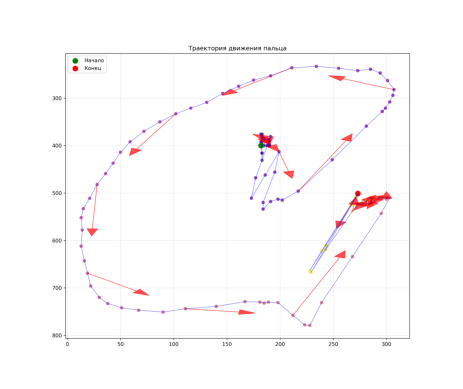

In [36]:
trajectory_path = '/kaggle/working/output/trajectory_plot.png'
# Посмотрим на траекторию движения
image = cv2.imread(trajectory_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Отображение изображения с использованием matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Отключить оси
plt.show()

## Реализация open_source решением MediaPipe

In [37]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0

In [38]:
import mediapipe as mp


def extract_trajectory_from_video(video_path):
    # Инициализация MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(min_detection_confidence=0.2, min_tracking_confidence=0.5)
    
    # Открываем видео
    cap = cv2.VideoCapture(video_path)
    
    # Список для хранения координат
    trajectory = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Конец видео

        # BGR → RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Обработка кадра с помощью MediaPipe
        results = hands.process(frame_rgb)
        
        if results.multi_hand_landmarks:
            for landmarks in results.multi_hand_landmarks:
                # Координаты кончика указательного пальца (точка 8)
                x = landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x
                y = landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y
                
                # Приведение координат к размеру изображения
                height, width, _ = frame.shape
                fingertip_xy = (int(x * width), int(y * height))
                
                trajectory.append(fingertip_xy)
        
        # Для отладки (если нужно, можно добавить отрисовку)
        # mp.solutions.drawing_utils.draw_landmarks(frame, landmarks)

    cap.release()
    return trajectory


2025-05-11 15:34:50.532749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746977690.787213      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746977690.861894      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1746977701.790124     160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746977701.825070     160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746977701.835997     161 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Извлечено 158 точек траектории


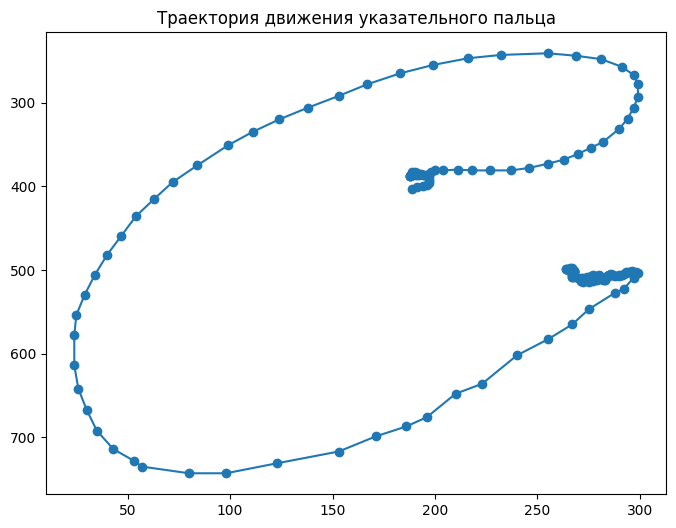

In [39]:
video_path = '/kaggle/input/videos/test_video.mp4'

trajectory = extract_trajectory_from_video(video_path)

print(f"Извлечено {len(trajectory)} точек траектории")

# Например, отобразить траекторию
import matplotlib.pyplot as plt

trajectory = np.array(trajectory)
plt.figure(figsize=(8,6))
plt.plot(trajectory[:,0], trajectory[:,1], marker='o')
plt.gca().invert_yaxis()  
plt.title("Траектория движения указательного пальца")
plt.show()
